In [1]:
# Use RoBERTa Model for Sentiment Analysis and classification with the Rating converted into labels (postive, neutral, negative)

In [2]:
# Import Libraries
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import DataCollatorWithPadding
import torch
import os
os.environ["WANDB_DISABLED"] = "true"

2024-10-14 17:04:15.856531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 17:04:15.856630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 17:04:15.857753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 17:04:15.864296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 17:04:16.631568: W tensorflow/compiler/tf2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import NaiveBayesClassifier      # NaiveBayes classifer for comparison with RoBERTa transformer model
import numpy as np
import re
import string
import nltk
%matplotlib inline

In [4]:
# Install Hugging Face Transformers and datasets
#!pip install transformers datasets # not needed to be installed any more!!!
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
df = pd.read_csv(r"dataset/1429_1.csv")
df.head()

/tmp/ipykernel_40/1209413327.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"dataset/1429_1.csv")


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [6]:
df.shape

(34660, 21)

In [7]:
# Drop rows where Rating ('Reviews.rating') is missing - about 33 of them in the entire 30K dataset (less than .1%) 
df = df.dropna(subset=['reviews.rating'])
df.shape

(34627, 21)

In [8]:
# Add a 'label' column based on 'reviews.rating' which will indicate if it's positive or negative
def label_sentiment(rating):
    if rating in [1, 2]:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply the function to create a new column
df['label'] = df['reviews.rating'].apply(label_sentiment)

# Drop rows where 'reviews.text' is missing (if any)
df = df.dropna(subset=['reviews.text'])

# Check the new DataFrame structure
print(df[['reviews.text', 'reviews.rating', 'label']].head())
print(df.shape)


                                        reviews.text  reviews.rating  label
0  This product so far has not disappointed. My c...             5.0      2
1  great for beginner or experienced person. Boug...             5.0      2
2  Inexpensive tablet for him to use and learn on...             5.0      2
3  I've had my Fire HD 8 two weeks now and I love...             4.0      2
4  I bought this for my grand daughter when she c...             5.0      2
(34626, 22)


In [9]:
# Split the dataset into Train and Validation set

train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviews.text'].tolist(), 
                                                                    df['label'].tolist(), 
                                                                    test_size=0.2, 
                                                                    random_state=42)

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")

Training set size: 27700
Validation set size: 6926


In [10]:
# Load pre-trained RoBERTa model for classification, this needs to be trained with our Data

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # 3 labels (negative, neutral, positive)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
# Due to the input dataset heavily skewed towards positive, need to introduce class weights into the model (to pump up the minority classes)
# No changes to the Dataset

from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import Trainer, TrainingArguments

# Step 1: Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Step 2: Modify the model to incorporate class weights in the loss function
class WeightedRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Perform the standard forward pass
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        
        # Compute the custom loss with class weights
        logits = outputs.logits
        if labels is not None:
             # Move class weights to the same device as the model (either CPU or GPU)
            self.class_weights = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)  # Incorporate class weights
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            # Return the loss within the SequenceClassifierOutput structure
            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions
            )
        else:
        
            return outputs

# Initialize the custom model with class weights

model = WeightedRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3, class_weights=class_weights_tensor)

# Move the weights to GPU as the model is already there
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

Some weights of WeightedRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WeightedRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [13]:
# Defining Training Argeuments - how the model will be trained 

training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=2,              # Number of training epochs changed EPOCH TO 3
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="steps",     # Evaluate every X steps
    logging_steps=500,               # Log every X steps
    save_steps=1000,                 # Save model every X steps
    save_total_limit=2,              # Save only the 2 most recent models
    load_best_model_at_end=True,     # Load the best model after training
    eval_steps=500                   # Evaluation frequency
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
# Create PyTorch datasets from the tokenized ones above, so it can be used in the Model

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasetsf
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [15]:
# CROSS-VALIDATION because the class is skewed to Positive (Ratings 4 & 5) after the Class_weights implementation

from sklearn.model_selection import StratifiedKFold
import numpy as np

# Prepare for Stratified K-Fold Cross-Validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert your encodings and labels to NumPy arrays for easier splitting
all_encodings_np = {key: np.array(val) for key, val in train_dataset.encodings.items()}
all_labels_np = np.array(train_dataset.labels)

# List to store results for each fold
fold_results = []

# Start Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(all_labels_np, all_labels_np)):  # stratified split
    print(f"Training fold {fold+1}/{n_splits}")

    # Create the training and validation datasets for this fold
    train_encodings_fold = {key: val[train_idx] for key, val in all_encodings_np.items()}
    val_encodings_fold = {key: val[val_idx] for key, val in all_encodings_np.items()}
    
    train_labels_fold = all_labels_np[train_idx]
    val_labels_fold = all_labels_np[val_idx]

    # Create PyTorch datasets for this fold from the numpy Arrays ///****** Important step as only Pytorch can be processed by RoBERTa  model **///
    train_dataset_fold = SentimentDataset(train_encodings_fold, train_labels_fold)
    val_dataset_fold = SentimentDataset(val_encodings_fold, val_labels_fold)

    # Initialize Trainer for this fold
    trainer = Trainer(
        model=model,                         # Pre-trained RoBERTa model
        args=training_args,                  # Training arguments
        train_dataset=train_dataset_fold,    # Training dataset for the current fold
        eval_dataset=val_dataset_fold,       # Validation dataset for the current fold
        tokenizer=tokenizer,                 # Tokenizer
        data_collator=data_collator          # Data collator for padding
    )

    # Train the model on this fold
    trainer.train()

    # Evaluate the model on the validation set for this fold
    eval_results = trainer.evaluate()
    
    # Save the results for this fold
    fold_results.append(eval_results)
    
    # Print results for this fold
    print(f"Results for fold {fold+1}: {eval_results}")

# After all folds, aggregate and print the results
avg_results = {
    metric: np.mean([fold[metric] for fold in fold_results])
    for metric in fold_results[0].keys()
}

print(f"Average Cross-Validation Results: {avg_results}")


Training fold 1/5


Step,Training Loss,Validation Loss
500,1.094000,0.825803
1000,1.137900,1.227443
1500,1.071500,1.145669
2000,1.040900,1.229092
2500,0.994600,0.895419


Results for fold 1: {'eval_loss': 1.2274426221847534, 'eval_runtime': 8.8597, 'eval_samples_per_second': 625.302, 'eval_steps_per_second': 9.82, 'epoch': 2.0}
Training fold 2/5


Step,Training Loss,Validation Loss
500,1.056700,1.159286
1000,1.074300,1.239301
1500,1.071900,1.240097
2000,1.077500,1.136408
2500,1.058800,1.154861


Results for fold 2: {'eval_loss': 1.1364084482192993, 'eval_runtime': 8.8814, 'eval_samples_per_second': 623.777, 'eval_steps_per_second': 9.796, 'epoch': 2.0}
Training fold 3/5


Step,Training Loss,Validation Loss
500,1.047400,1.208598
1000,1.075400,1.138236
1500,1.044600,1.216893
2000,1.081600,1.153596
2500,0.994800,1.321753


Results for fold 3: {'eval_loss': 1.1382358074188232, 'eval_runtime': 8.8447, 'eval_samples_per_second': 626.363, 'eval_steps_per_second': 9.836, 'epoch': 2.0}
Training fold 4/5


Step,Training Loss,Validation Loss
500,1.062600,1.163069
1000,1.070200,1.149964
1500,1.056200,1.136532
2000,1.060800,1.174255
2500,1.059700,1.172368


Results for fold 4: {'eval_loss': 1.1499637365341187, 'eval_runtime': 8.8594, 'eval_samples_per_second': 625.325, 'eval_steps_per_second': 9.82, 'epoch': 2.0}
Training fold 5/5


Step,Training Loss,Validation Loss
500,1.081900,1.195538
1000,1.019400,1.206365
1500,1.064200,1.170004
2000,1.070600,1.239794
2500,1.081300,1.172782


Results for fold 5: {'eval_loss': 1.2063648700714111, 'eval_runtime': 8.8764, 'eval_samples_per_second': 624.129, 'eval_steps_per_second': 9.801, 'epoch': 2.0}
Average Cross-Validation Results: {'eval_loss': 1.171683096885681, 'eval_runtime': 8.864320000000001, 'eval_samples_per_second': 624.9792, 'eval_steps_per_second': 9.8146, 'epoch': 2.0}


In [16]:
""" # Initialize the Trainer - with all the defined info from above.
trainer = Trainer(
    model=model,                         # pre-trained RoBERTa model
    args=training_args,                  # Training arguments as defined above
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=val_dataset,            # Validation dataset
    tokenizer=tokenizer,                 # Tokenizer
    data_collator=data_collator          # Data collator for padding
) """


' # Initialize the Trainer - with all the defined info from above.\ntrainer = Trainer(\n    model=model,                         # pre-trained RoBERTa model\n    args=training_args,                  # Training arguments as defined above\n    train_dataset=train_dataset,         # Training dataset\n    eval_dataset=val_dataset,            # Validation dataset\n    tokenizer=tokenizer,                 # Tokenizer\n    data_collator=data_collator          # Data collator for padding\n) '

In [17]:
""" # Train the model now to fine-tune the model for our customer review purposes
trainer.train() """

' # Train the model now to fine-tune the model for our customer review purposes\ntrainer.train() '

In [18]:
# Save the model and tokenizer
model.save_pretrained("./sentiment-analysis-roberta-CrossV-Classweight2")
tokenizer.save_pretrained("./sentiment-analysis-roberta-CrossV-Classweight2")


('./sentiment-analysis-roberta-CrossV-Classweight2/tokenizer_config.json',
 './sentiment-analysis-roberta-CrossV-Classweight2/special_tokens_map.json',
 './sentiment-analysis-roberta-CrossV-Classweight2/vocab.json',
 './sentiment-analysis-roberta-CrossV-Classweight2/merges.txt',
 './sentiment-analysis-roberta-CrossV-Classweight2/added_tokens.json')

In [19]:
""" from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Reload model and tokenizer
model = RobertaForSequenceClassification.from_pretrained("./sentiment-analysis-roberta")
tokenizer = RobertaTokenizer.from_pretrained("./sentiment-analysis-roberta") """


' from transformers import RobertaForSequenceClassification, RobertaTokenizer\n\n# Reload model and tokenizer\nmodel = RobertaForSequenceClassification.from_pretrained("./sentiment-analysis-roberta")\ntokenizer = RobertaTokenizer.from_pretrained("./sentiment-analysis-roberta") '

In [20]:
# Evaluate the model using validation data
results = trainer.evaluate()
print(results)

# Get the predictions and labels from the evaluation set
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids


{'eval_loss': 1.2063648700714111, 'eval_runtime': 8.8728, 'eval_samples_per_second': 624.383, 'eval_steps_per_second': 9.805, 'epoch': 2.0}


Accuracy: 0.9371931850996246
Precision: 0.8783310661971793
Recall: 0.9371931850996246
F1-Score: 0.9068079249432307
Confusion Matrix:
[[   0    0  157]
 [   0    0  278]
 [   0    0 6491]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


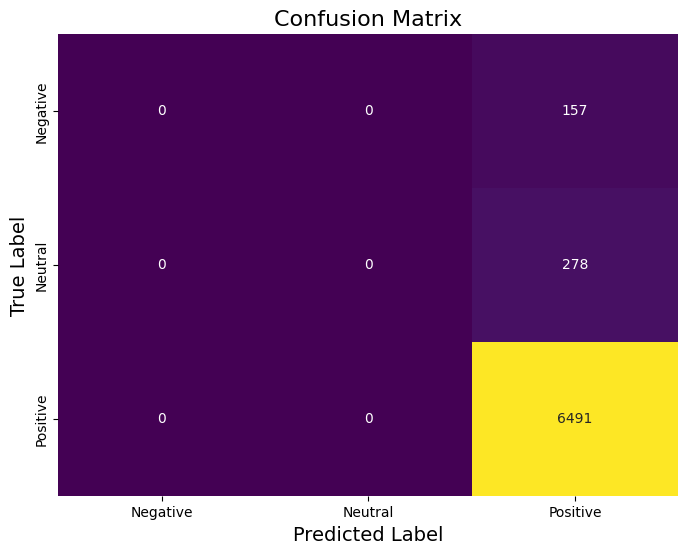

In [21]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False, 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])

# Add labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Display the plot
plt.show()

In [22]:
""" import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Assuming predictions and labels are obtained from trainer.predict(val_dataset)
predictions = trainer.predict(val_dataset)
preds_prob = predictions.predictions  # Get probabilities (logits)
labels = predictions.label_ids  # True labels

# If your labels are multi-class, you need to binarize them for ROC
# For binary classification (e.g., Positive vs Negative), use the positive class probabilities
# In this case, let's assume class 2 is positive (adjust based on your classes)
preds_positive_prob = preds_prob[:, 2]  # Extract positive class probabilities

# Get false positive rate (FPR), true positive rate (TPR), and thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(labels, preds_positive_prob, pos_label=2)

# Calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, color='b', lw=2, label='RoBERTa: AUC = %0.2f' % roc_auc)

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RoBERTa Model')
plt.legend(loc='lower right')

# Show the plot
plt.show() """


" import matplotlib.pyplot as plt\nimport numpy as np\nfrom sklearn.metrics import roc_curve, auc\n\n# Assuming predictions and labels are obtained from trainer.predict(val_dataset)\npredictions = trainer.predict(val_dataset)\npreds_prob = predictions.predictions  # Get probabilities (logits)\nlabels = predictions.label_ids  # True labels\n\n# If your labels are multi-class, you need to binarize them for ROC\n# For binary classification (e.g., Positive vs Negative), use the positive class probabilities\n# In this case, let's assume class 2 is positive (adjust based on your classes)\npreds_positive_prob = preds_prob[:, 2]  # Extract positive class probabilities\n\n# Get false positive rate (FPR), true positive rate (TPR), and thresholds\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(labels, preds_positive_prob, pos_label=2)\n\n# Calculate AUC\nroc_auc = auc(false_positive_rate, true_positive_rate)\n\n# Plot the ROC curve\nplt.figure(figsize=(8, 6))\nplt.plot(false_posi

In [23]:
# Extract the 'text' from the val_dataset which is a Tensorfile now.
texts = val_texts  # This should be a list of the review texts used for validation

# Create a DataFrame with the texts, true labels, and predicted labels
df_results = pd.DataFrame({
    'Text': texts,
    'True Label': labels,
    'Predicted Label': preds
})

# Save the DataFrame as a CSV file for further analysis
df_results.to_csv("val_predictions1.csv", index=False)

print("Predictions saved to 'val_predictions2.csv'.")

Predictions saved to 'val_predictions2.csv'.


In [24]:
# DEFINE THE CUDA statement so it can pick up from GPU or speaker

# Example: Inference with new review
new_review = "This product is amazing, I love it!"
inputs = tokenizer(new_review, return_tensors="pt", truncation=True, padding=True, max_length=128)

# Get model predictions
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
print(f"Sentiment: {label_mapping[predictions.item()]}")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)